In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
faizalkarim_flood_area_segmentation_path = kagglehub.dataset_download('faizalkarim/flood-area-segmentation')

print('Data source import complete.')

100%|██████████| 107M/107M [00:05<00:00, 20.3MB/s] 

Extracting model files...


Data source import complete.


In [1]:
# import system libs
import os
import time
import glob
import shutil

# import data handling tools
import cv2
import PIL
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
import tensorflow.image as tfi
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D,  MaxPool2D, UpSampling2D, concatenate, Activation
from tensorflow.keras.layers import Layer, Input, Add, Multiply, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2025-04-20 10:04:11.260728: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-20 10:04:11.272101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745154251.285092   95537 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745154251.288650   95537 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745154251.300230   95537 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

2.19.0
modules loaded


In [2]:
# --- Definição da função create_data ---
def create_data(data_dir):
    image_paths = []
    mask_paths = []

    folds = sorted(os.listdir(data_dir))
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        if fold in ['image', 'Image', 'images', 'Images', 'IMAGES']:
            images = sorted(os.listdir(foldpath))
            for image in images:
                fpath = os.path.join(foldpath, image)
                image_paths.append(fpath)

        elif fold in ['mask', 'Mask', 'masks', 'Masks', 'MASKS']:
            masks = sorted(os.listdir(foldpath))
            for mask in masks:
                fpath = os.path.join(foldpath, mask)
                mask_paths.append(fpath)
        else:
            continue

    return image_paths, mask_paths

In [3]:
# --- Definição da função load_image ---
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image)) / 255., (SIZE, SIZE)), 4)

# --- Definição da função load_images ---
def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    channels = 1 if mask else 3
    images = np.zeros((len(image_paths), SIZE, SIZE, channels))
    for i, image in enumerate(image_paths):
        img = load_image(image, SIZE)
        images[i] = img[:, :, :1] if mask else img
    return images

In [4]:
# --- Definição da função show_image ---
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# --- Definição da função show_mask ---
def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

# --- Definição da função show_images ---
def show_images(imgs, msks):
    plt.figure(figsize=(13,8))

    for i in range(15):
        plt.subplot(3,5,i+1)
        id = np.random.randint(len(imgs))
        show_mask(imgs[id], msks[id], cmap='binary')

    plt.tight_layout()
    plt.show()

In [5]:
# --- Funções de perda personalizadas ---
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jaccard_loss(y_true, y_pred):
    smooth = 1.
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1,2,3])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return 1 - jac

def combined_loss(y_true, y_pred):
    # Calcula a média das perdas dice e jaccard ao longo do lote
    dice = tf.reduce_mean(dice_loss(y_true, y_pred))
    jaccard = tf.reduce_mean(jaccard_loss(y_true, y_pred))
    # Agora, 'dice' e 'jaccard' têm shape [1] (escalar)

    return keras.losses.binary_crossentropy(y_true, y_pred) + dice + jaccard

In [6]:
# --- Bloco Residual ERFNet ---
def residual_block(x, filters, dilation=1):
    shortcut = x
    x = Conv2D(filters, 3, padding='same', dilation_rate=dilation)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same', dilation_rate=dilation)(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [7]:
# --- Modelo ERFNet-like ---
def erfnet_like(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for _ in range(3):
        x = residual_block(x, 32, dilation=1)

    x = Conv2D(64, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for _ in range(3):
        x = residual_block(x, 64, dilation=2)

    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for _ in range(3):
        x = residual_block(x, 128, dilation=4)

    # Decoder
    x = UpSampling2D()(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = UpSampling2D()(x)
    x = Conv2D(32, 3, padding='same', activation='relu')(x)
    x = UpSampling2D()(x)
    outputs = Conv2D(1, 1, activation='sigmoid')(x)

    return Model(inputs, outputs)

In [8]:
# --- Definição da função plot_training ---
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''
    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'


2025-04-20 10:12:14.971143: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-04-20 10:12:14.971171: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-04-20 10:12:14.971176: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: jupiter
2025-04-20 10:12:14.971178: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: jupiter
2025-04-20 10:12:14.971337: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 570.124.6
2025-04-20 10:12:14.971360: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported version is: 570.124.4
2025-

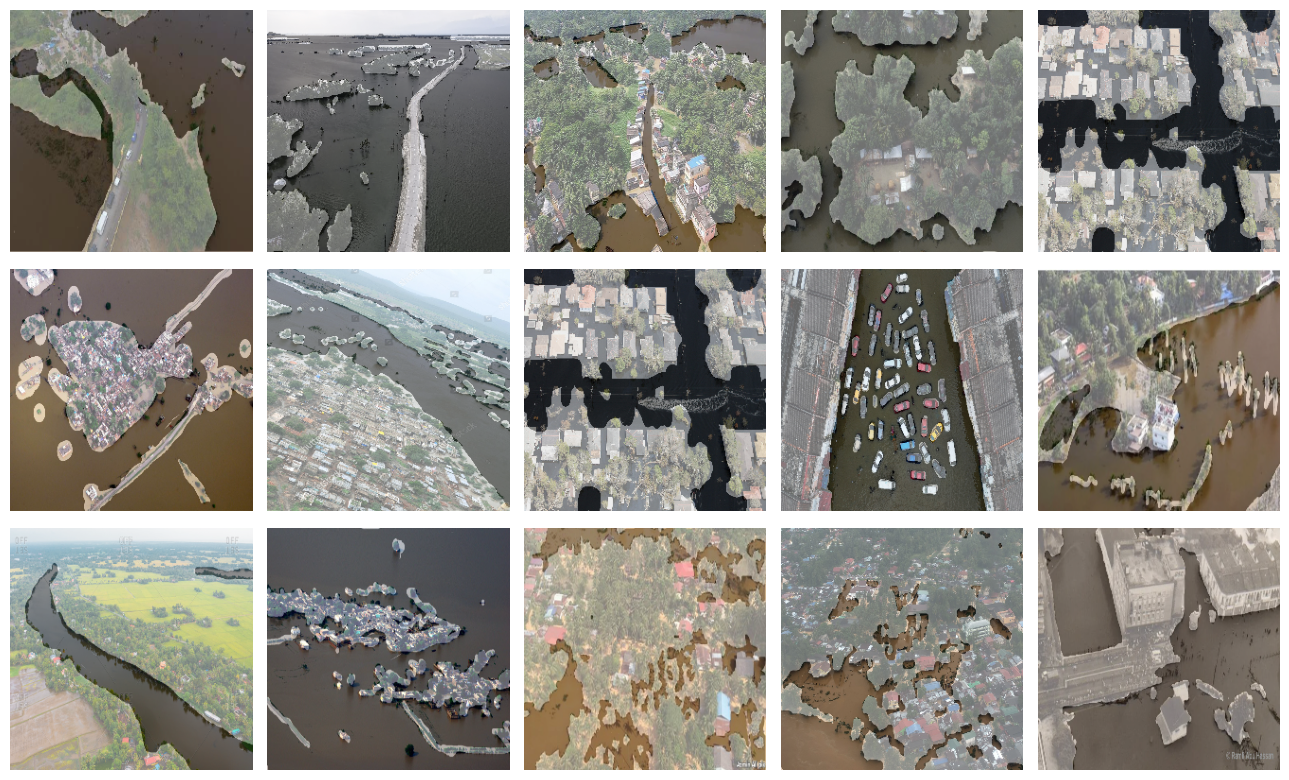

In [ ]:
# --- Definição do tamanho da imagem ---
SIZE = 256

# --- Carregamento dos dados ---
data_dir = faizalkarim_flood_area_segmentation_path
image_paths, mask_paths = create_data(data_dir)

# --- Carregamento das imagens e máscaras ---
imgs = load_images(image_paths, SIZE)
msks = load_images(mask_paths, SIZE, mask=True)

# --- Exibição de amostras ---
show_images(imgs, msks)

In [10]:
# --- Criação do Modelo ERFNet-like ---
model = erfnet_like((SIZE, SIZE, 3))

# --- Compilação do Modelo ---
model.compile(optimizer='adam',
              loss=combined_loss,
              metrics=['accuracy', 'binary_crossentropy']) # Binary Crossentropy como métrica

# --- Resumo do Modelo ---
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_3[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 1,354,369 (5.17 MB)

 Trainable params: 1,351,233 (5.15 MB)

 Non-trainable params: 3,136 (12.25 KB)

In [11]:
# --- Definição dos parâmetros de treinamento ---
batch_size = 16     # Tamanho do lote para treinamento (ajustado para ERFNet)
epochs = 2         # Número total de épocas de treinamento (ajustado para ERFNet)
ask_epoch = 5       # Número de épocas para executar antes de perguntar se deseja interromper o treinamento

callbacks = [
    ModelCheckpoint("flood_segmentation_erfnet_best.keras", save_best_only=True, monitor='val_loss', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

In [12]:
# --- Configuração do número de passos por época ---
SPE = len(imgs)//batch_size

# --- Treinamento do Modelo ---
history = model.fit(
    imgs, msks,
    validation_split=0.2,
    epochs=epochs,
    verbose=1,
    steps_per_epoch=SPE,
    batch_size=batch_size,
    callbacks=callbacks # Usando callbacks padrão
)

Epoch 1/2


2025-04-20 10:13:05.619508: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


15/18 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6209 - binary_crossentropy: 0.7481 - loss: 1.8105
Epoch 1: val_loss improved from inf to 2.26800, saving model to flood_segmentation_erfnet_best.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6329 - binary_crossentropy: 0.7301 - loss: 1.7742 - val_accuracy: 0.3547 - val_binary_crossentropy: 1.0540 - val_loss: 2.2680
Epoch 2/2
15/18 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8004 - binary_crossentropy: 0.4692 - loss: 1.1698
Epoch 2: val_loss did not improve from 2.26800
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8009 - binary_crossentropy: 0.4686 - loss: 1.1692 - val_accuracy: 0.3363 - val_binary_crossentropy: 1.2965 - val_loss: 2.4681
Restoring model weights from the end of the best epoch: 1.


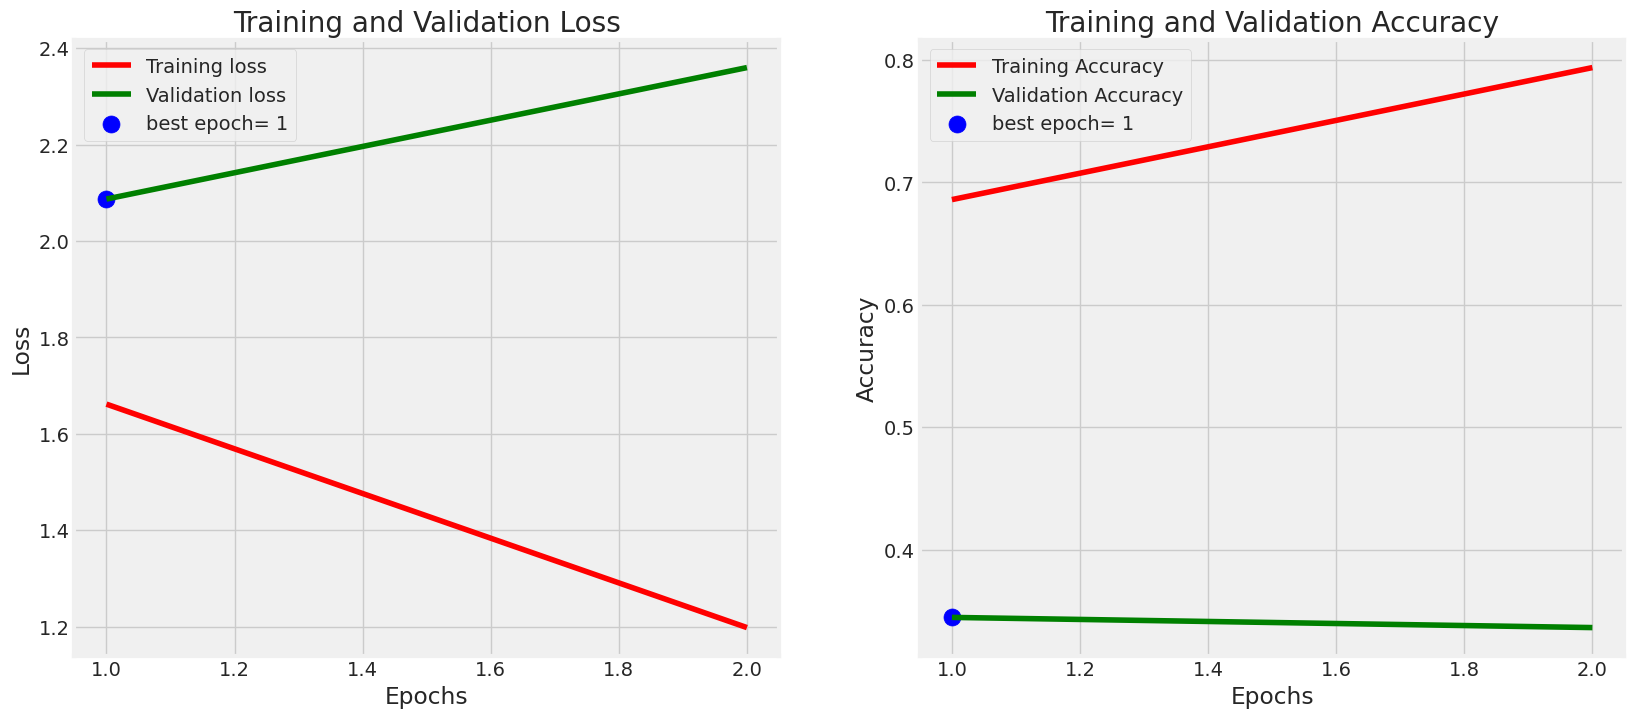

In [14]:
# --- Plotagem do Histórico de Treinamento ---
plot_training(history)

2025-04-20 00:33:15.570216: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.83 = (f32[4,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,34,34]{3,2,1,0} %bitcast.2785, f32[64,64,3,3]{3,2,1,0} %bitcast.2792, f32[64]{0} %bitcast.2794), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_8_1/convolution" source_file="/home/gabriel/anaconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-20 00:33:15.665057: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially bu

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


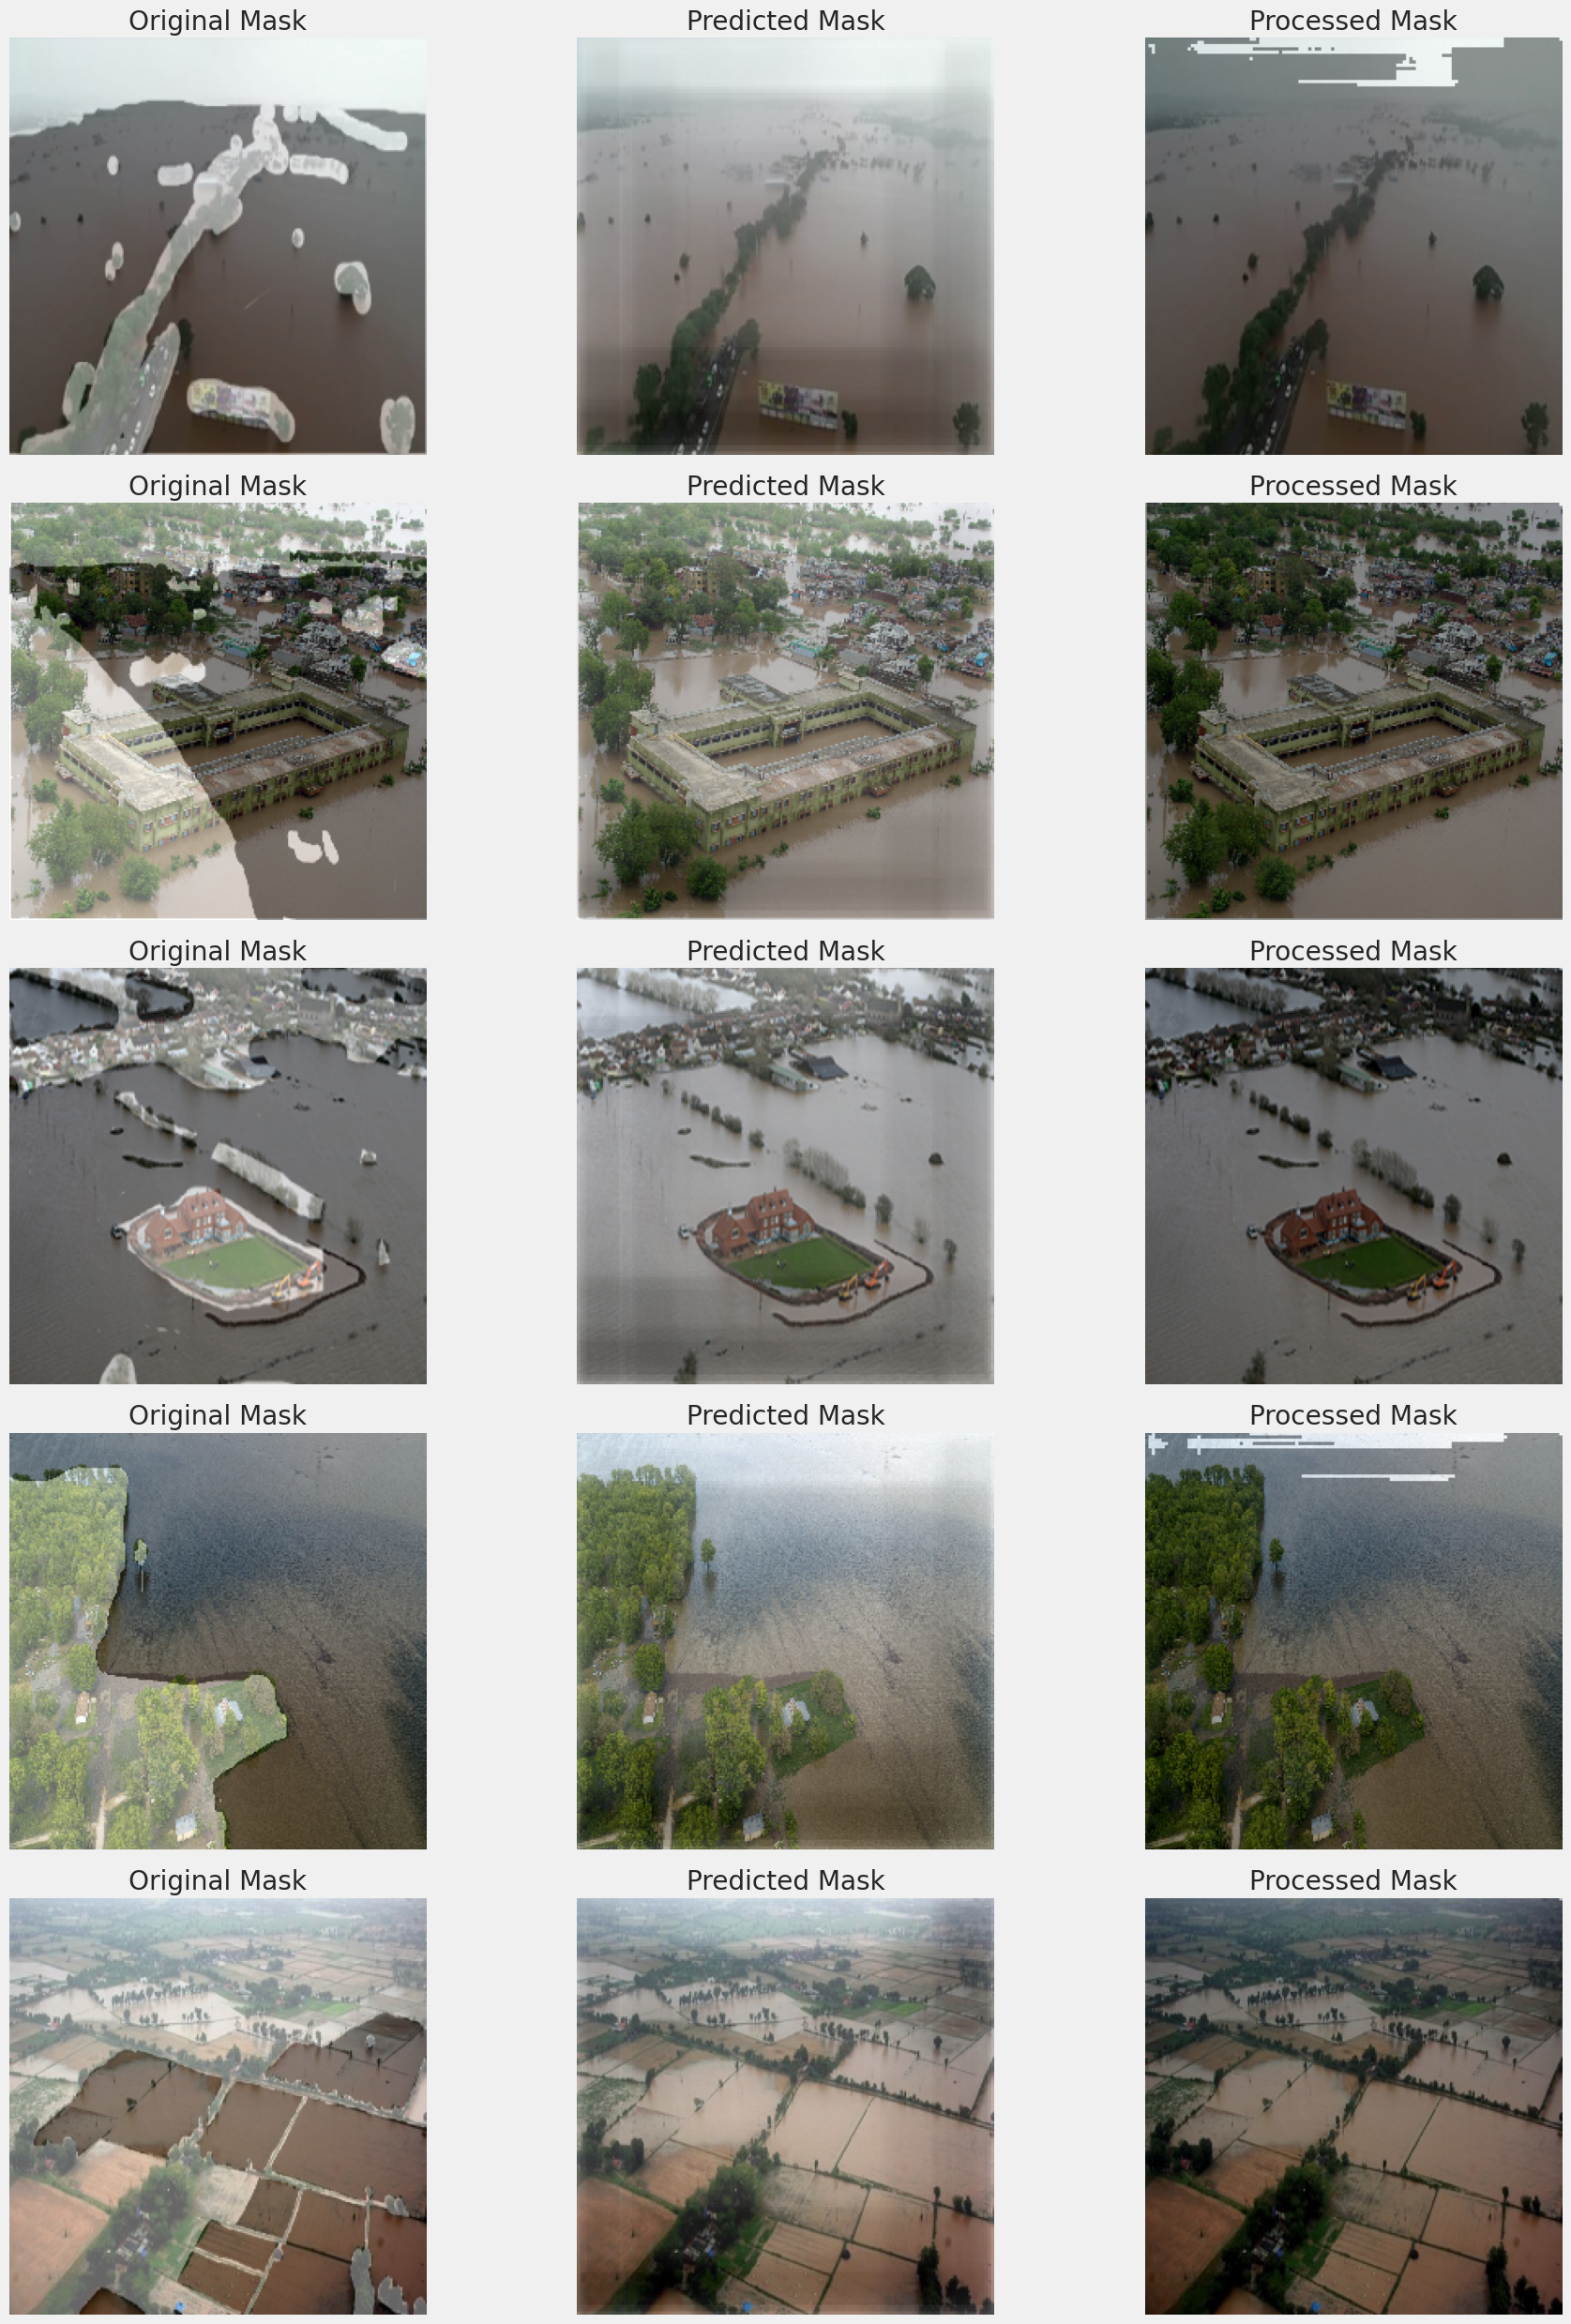

In [15]:
# --- Visualização das Máscaras Preditas ---
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(imgs))
        image = imgs[id]
        mask = msks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask, cmap='binary')
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='binary')
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask, cmap='binary')
        n=0
plt.tight_layout()
plt.show()